# how many novel lncRNAs are quantified?

evidence that the new lncRNAs are expressed/quantifiable in v10 vs v11.

v10 used gencode 46 with 19000 lncRNAs, v11 uses gencode 47 with 35000 lncRNAs

In [1]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os

from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47792990/ipykernel_56405/889698852.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [2]:
gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode.v39.genes.gtf"
gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.genes.gtf"
full_gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode.v39.annotation.gtf"
full_gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.annotation.gtf"

v10_quantificaiton_path = "/home/klawren/oak/gtex/data/other_references/v10/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
v11_quantificaiton_dir = "/home/klawren/oak/gtex/output/caudate_analysis"

### comparison of gencode annotations

In [3]:
# load in gencode for lncRNA annotations
gencode_v47=pr.read_gtf(gencode_v47_path).as_df()
gencode_v39=pr.read_gtf(gencode_v39_path).as_df()

In [ ]:
full_gencode_v47=pr.read_gtf(full_gencode_v47_path).as_df()
full_gencode_v39=pr.read_gtf(full_gencode_v39_path).as_df()

In [ ]:
# drop duplicates (multiple transcripts of same gene) 
gencode_v39 = gencode_v39.drop_duplicates('gene_id')
gencode_v47 = gencode_v47.drop_duplicates('gene_id')

gencode_v47['gene_id_stable'] = gencode_v47['gene_id'].str.split('.').str[0]
gencode_v39['gene_id_stable'] = gencode_v39['gene_id'].str.split('.').str[0]
full_gencode_v39['gene_id_stable'] = full_gencode_v39['gene_id'].str.split('.').str[0]
full_gencode_v47['gene_id_stable'] = full_gencode_v47['gene_id'].str.split('.').str[0]

In [ ]:
# harmonize annotation categories as in https://www.gencodegenes.org/pages/biotypes.html
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'lncRNA', gencode_v39['gene_type'])
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type_harmonized'].isin(['vaultRNA']), 'vault_RNA', gencode_v39['gene_type_harmonized'])

In [ ]:
gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type').size(), 'v39':gencode_v39.groupby('gene_type_harmonized').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47791421/ipykernel_29444/3796981686.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


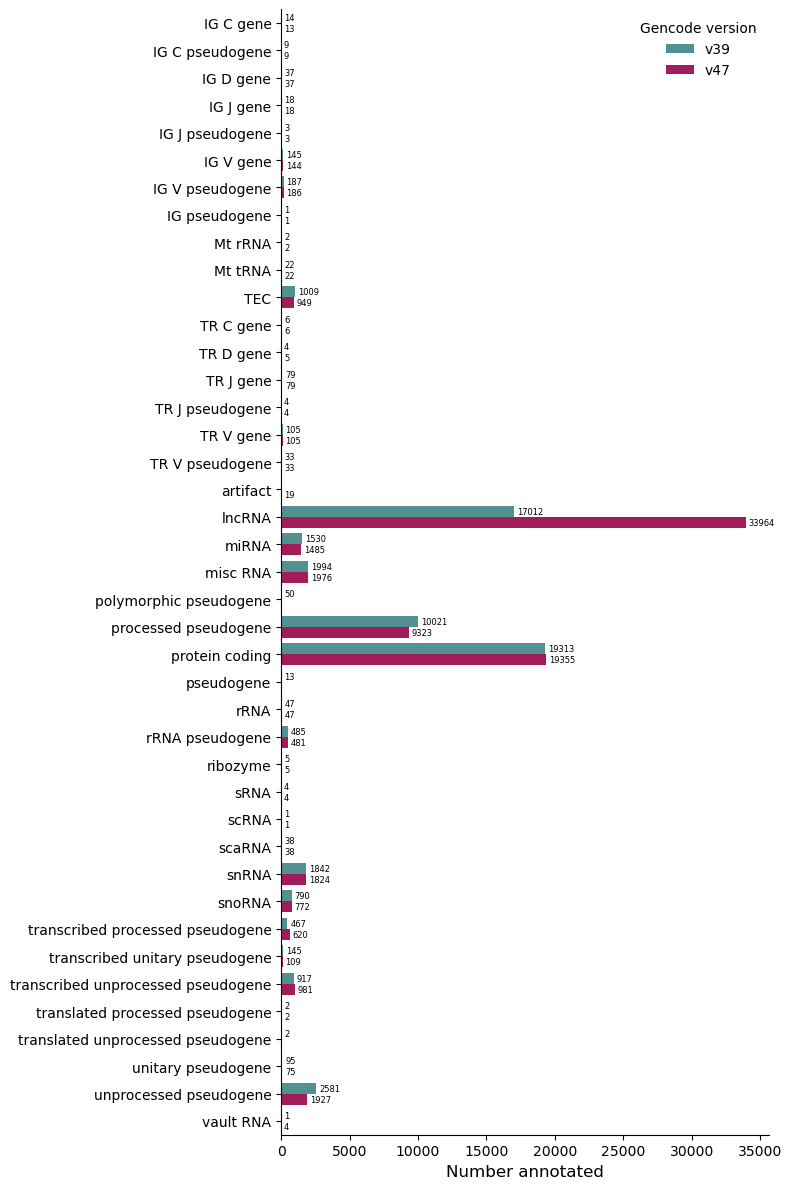

In [ ]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=['#4a989c', '#b70657'])

#ax.set_xscale('log')

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

In [ ]:
# group some categories 
def group_gene_type(gencode_df):
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_rRNA',
                                                                                            'Mt_tRNA',
                                                                                            'miRNA',
                                                                                            'misc_RNA',
                                                                                            'rRNA',
                                                                                            'scRNA',
                                                                                            'snRNA',
                                                                                            'snoRNA',
                                                                                            'ribozyme',
                                                                                            'sRNA',
                                                                                            'scaRNA',
                                                                                            'vault_RNA']), 'noncoding_RNA', gencode_df['gene_type_harmonized'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_tRNA_pseudogene',
                                                                                            'tRNA_pseudogene',
                                                                                            'snoRNA_pseudogene',
                                                                                            'snRNA_pseudogene',
                                                                                            'scRNA_pseudogene',
                                                                                            'rRNA_pseudogene',
                                                                                            'misc_RNA_pseudogene',
                                                                                            'miRNA_pseudogene']), 'noncoding_RNA_pseudogene', gencode_df['gene_type_grouped'])
    

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_grouped'].isin(['noncoding_RNA_pseudogene']),'noncoding_RNA', gencode_df['gene_type_grouped'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['transcribed_processed_pseudogene',
                                                                                            'transcribed_unprocessed_pseudogene',
                                                                                            'transcribed_unitary_pseudogene',
                                                                                            'translated_processed_pseudogene',
                                                                                            'translated_unprocessed_pseudogene',
                                                                                            'unitary_pseudogene',
                                                                                            'unprocessed_pseudogene',
                                                                                            'pseudogene',
                                                                                            'polymorphic_pseudogene',
                                                                                            'processed_pseudogene',
                                                                                            'IG_C_pseudogene', 
                                                                                            'IG_J_pseudogene', 
                                                                                            'IG_V_pseudogene', 
                                                                                            'IG_pseudogene',
                                                                                            'TR_V_pseudogene',
                                                                                            'TR_J_pseudogene']), 'pseudogene', gencode_df['gene_type_grouped'])
    
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['protein_coding', 
                                                                                        'TEC',
                                                                                        'IG_C_gene', 
                                                                                        'IG_D_gene', 
                                                                                        'IG_J_gene',
                                                                                        'IG_V_gene', 
                                                                                        'TR_C_gene',
                                                                                        'TR_J_gene',
                                                                                        'TR_V_gene',
                                                                                        'TR_D_gene']), 'protien_coding_or_TEC', gencode_df['gene_type_grouped'])


In [ ]:
gencode_v47['gene_type_harmonized'] = gencode_v47['gene_type']
group_gene_type(gencode_v47)
group_gene_type(gencode_v39)

gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type_grouped').size(), 'v39':gencode_v39.groupby('gene_type_grouped').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47791421/ipykernel_29444/3733569505.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


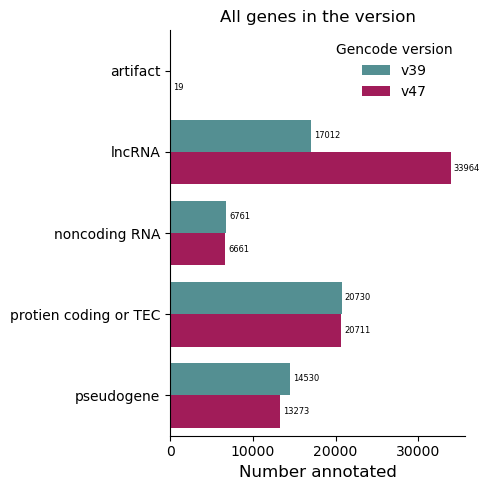

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=[ '#4a989c', '#b70657'])

ax.set_title('All genes in the version')

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

In [ ]:
print('{} gencode v47 aren\'t in gencode v39'.format(sum(~gencode_v47['gene_id_stable'].isin(gencode_v39['gene_id_stable']))))
print('{} gencode v39 aren\'t in gencode v47'.format(sum(~gencode_v39['gene_id_stable'].isin(gencode_v47['gene_id_stable']))))

18154 gencode v47 aren't in gencode v39
2518 gencode v39 aren't in gencode v47


In [ ]:
gene_type_counts = pd.DataFrame({'v47':gencode_v47[~gencode_v47['gene_id_stable'].isin(gencode_v39['gene_id_stable'])].groupby('gene_type_grouped').size(), 'v39':gencode_v39[~gencode_v39['gene_id_stable'].isin(gencode_v47['gene_id_stable'])].groupby('gene_type_grouped').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47791421/ipykernel_29444/3799024315.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


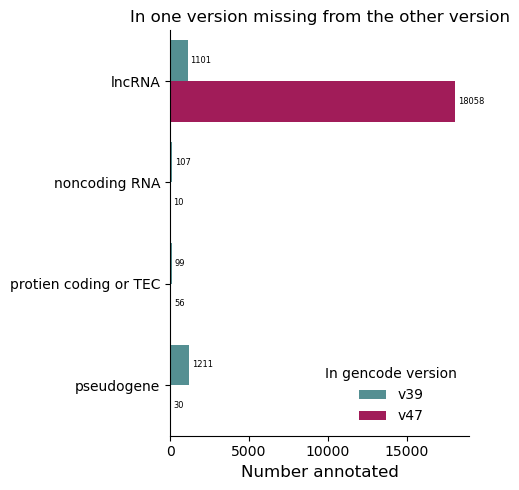

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=[ '#4a989c', '#b70657'])

ax.set_title('In one version missing from the other version')
ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("In gencode version")

plt.tight_layout() 
plt.show()

In [ ]:
# what is up with the missing ones? are they in the full gft? are the renamed??
missing_v47 = gencode_v39[~gencode_v39['gene_id_stable'].isin(gencode_v47['gene_id_stable'])]
print('{} are in v39 and not in v47'.format(len(missing_v47)))
missing_v47_in_full = missing_v47[missing_v47['gene_id_stable'].isin(full_gencode_v47['gene_id_stable'])]
print('\t{} are in the full gtf - likely cut because overlapping'.format(len(missing_v47_in_full)))
missing_v47_not_full = missing_v47[~missing_v47['gene_id_stable'].isin(full_gencode_v47['gene_id_stable'])]
print('\nremaining missing genes are:')
print(missing_v47_not_full['gene_type_harmonized'].value_counts())

2518 are in v39 and not in v47
	1374 are in the full gtf - likely cut because overlapping

remaining missing genes are:
gene_type_harmonized
lncRNA                                1069
TEC                                     30
protein_coding                          18
pseudogene                              13
processed_pseudogene                     5
unprocessed_pseudogene                   3
transcribed_processed_pseudogene         2
transcribed_unitary_pseudogene           2
transcribed_unprocessed_pseudogene       1
snoRNA                                   1
Name: count, dtype: int64


In [ ]:
# def is_collapsed(sample_missing):
#     v39_gene = full_gencode_v39[(full_gencode_v39['gene_id_stable'] == sample_missing['gene_id_stable']) & (full_gencode_v39['Feature'] == 'gene')].iloc[0]
#     matched_location_v47 = full_gencode_v47[(full_gencode_v47['Chromosome'] == v39_gene['Chromosome']) & (full_gencode_v47['Start'] == v39_gene['Start']) & (full_gencode_v47['End'] == v39_gene['End'])  & (full_gencode_v47['Feature'].isin(['gene', 'transcript']))]
#     return len(matched_location_v47) > 0
# collapsed_bool = missing_v47_not_full.progress_apply(is_collapsed, axis=1)
# missing_v47_not_full['is_collapsed'] = collapsed_bool
# missing_v47_not_full[~missing_v47_not_full['is_collapsed']].to_csv('data/other_references/missing_v47_ids.txt', sep='\t')

missing_v47 = pd.read_csv('data/other_references/missing_v47_ids.txt', sep='\t')
missing_v47.head()

In [362]:
sample_missing = missing_v47_not_full.iloc[2]
gencode_v39[gencode_v39['gene_id_stable'] == sample_missing['gene_id_stable']]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,...,transcript_name,level,hgnc_id,havana_gene,exon_id,exon_number,tag,gene_id_stable,gene_type_harmonized,gene_type_grouped
143,chr1,HAVANA,gene,914948,914971,.,+,.,ENSG00000241180.1,ENSG00000241180.1,...,ENSG00000241180,2,NaN,OTTHUMG00000040717.2,NaN,NaN,overlapping_locus,ENSG00000241180,lncRNA,lncRNA


In [363]:
# collapsed gtf can be trimmed, get the orig gene
v39_gene = full_gencode_v39[(full_gencode_v39['gene_id_stable'] == sample_missing['gene_id_stable']) & (full_gencode_v39['Feature'] == 'gene')]
v39_gene

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_stable
515,chr1,HAVANA,gene,914170,914971,.,+,.,ENSG00000241180.1,lncRNA,...,NaN,NaN,overlapping_locus,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000241180


In [364]:
# does the v39 gene match any new v47 genes but under a different name?
v39_gene = v39_gene.iloc[0]
matched_location_v47 = full_gencode_v47[(full_gencode_v47['Chromosome'] == v39_gene['Chromosome']) & (full_gencode_v47['Start'] > v39_gene['Start'] - 10) & (full_gencode_v47['End'] < v39_gene['End'] + 10)  & (full_gencode_v47['Feature'].isin(['gene', 'transcript']))]
matched_location_v47

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,exon_id,transcript_support_level,havana_transcript,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl,gene_id_stable
1531,chr1,HAVANA,transcript,914170,914971,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,NaN,NaN,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438


In [365]:
# if yse, is that v47 id part of v 39?
full_gencode_v39[(full_gencode_v39['gene_id_stable'] == matched_location_v47['gene_id_stable'].iloc[0]) & (full_gencode_v39['Feature'].isin(['gene']))]
# if there are matches, then this was a case of two v39 ids being combined into 1 v47 id

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_stable
507,chr1,HAVANA,gene,904833,915976,.,+,.,ENSG00000272438.1,lncRNA,...,NaN,NaN,overlapping_locus,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000272438


In [366]:
full_gencode_v39[(full_gencode_v39['Chromosome'] == sample_missing['Chromosome']) & (full_gencode_v39['Start'] > sample_missing['Start'] - 1000) & (full_gencode_v39['End'] < sample_missing['End'] + 1000)  & (full_gencode_v39['Feature'].isin(['gene', 'transcript']))]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_stable
515,chr1,HAVANA,gene,914170,914971,.,+,.,ENSG00000241180.1,lncRNA,...,NaN,NaN,overlapping_locus,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000241180
516,chr1,HAVANA,transcript,914170,914971,.,+,.,ENSG00000241180.1,lncRNA,...,ENST00000398216,3,Ensembl_canonical,OTTHUMT00000097857.2,NaN,NaN,NaN,NaN,NaN,ENSG00000241180


In [337]:
full_gencode_v47[(full_gencode_v47['Chromosome'] == sample_missing['Chromosome']) & (full_gencode_v47['Start'] > sample_missing['Start'] - 1000) & (full_gencode_v47['End'] < sample_missing['End'] + 1000)  & (full_gencode_v47['Feature'].isin(['gene', 'transcript']))]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,exon_id,transcript_support_level,havana_transcript,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl,gene_id_stable
1528,chr1,HAVANA,transcript,911434,914948,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,NaN,NaN,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438
1531,chr1,HAVANA,transcript,914170,914971,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,NaN,NaN,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438


In [339]:
full_gencode_v39[(full_gencode_v39['gene_id_stable'] == 'ENSG00000272438')]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_stable
507,chr1,HAVANA,gene,904833,915976,.,+,.,ENSG00000272438.1,lncRNA,...,NaN,NaN,overlapping_locus,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000272438
508,chr1,HAVANA,transcript,904833,915976,.,+,.,ENSG00000272438.1,lncRNA,...,ENST00000607769,4,Ensembl_canonical,OTTHUMT00000470696.1,NaN,NaN,NaN,NaN,NaN,ENSG00000272438
509,chr1,HAVANA,exon,904833,904957,.,+,.,ENSG00000272438.1,lncRNA,...,ENST00000607769,4,Ensembl_canonical,OTTHUMT00000470696.1,1,ENSE00003700027.1,NaN,NaN,NaN,ENSG00000272438
510,chr1,HAVANA,exon,915749,915976,.,+,.,ENSG00000272438.1,lncRNA,...,ENST00000607769,4,Ensembl_canonical,OTTHUMT00000470696.1,2,ENSE00003696845.1,NaN,NaN,NaN,ENSG00000272438


In [341]:
full_gencode_v47[(full_gencode_v47['Chromosome'] == sample_missing['Chromosome']) & (full_gencode_v47['Start'] > 904833 - 10) & (full_gencode_v47['End'] < 915976 + 10)  & (full_gencode_v47['Feature'].isin(['gene', 'transcript']))]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,exon_id,transcript_support_level,havana_transcript,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl,gene_id_stable
1460,chr1,HAVANA,transcript,904833,914971,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,NaN,NaN,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438
1464,chr1,HAVANA,transcript,904833,915976,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,4,OTTHUMT00000470696.1,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438
1487,chr1,HAVANA,transcript,904843,907390,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,NaN,NaN,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438
1528,chr1,HAVANA,transcript,911434,914948,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,NaN,NaN,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438
1531,chr1,HAVANA,transcript,914170,914971,.,+,.,ENSG00000272438.2,lncRNA,...,NaN,NaN,NaN,NaN,OTTHUMG00000185550.1,NaN,NaN,NaN,NaN,ENSG00000272438
203276,chr1,HAVANA,gene,908072,910592,.,-,.,ENSG00000298603.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000298603
203277,chr1,HAVANA,transcript,908072,910592,.,-,.,ENSG00000298603.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000298603


In [314]:
missing_v39 = gencode_v47[~gencode_v47['gene_id_stable'].isin(gencode_v39['gene_id_stable'])]
print('{} are in v47 and not in v39'.format(len(missing_v39)))
missing_v39_in_full = missing_v39[missing_v39['gene_id_stable'].isin(full_gencode_v39['gene_id_stable'])]
print('\t{} are in the full gtf - likely cut because overlapping'.format(len(missing_v39_in_full)))
missing_v39_not_full = missing_v39[~missing_v39['gene_id_stable'].isin(full_gencode_v39['gene_id_stable'])]
print('\nremaining missing genes are:')
print(missing_v39_not_full['gene_type_harmonized'].value_counts())

18154 are in v47 and not in v39
	101 are in the full gtf - likely cut because overlapping

remaining missing genes are:
gene_type_harmonized
lncRNA                                17970
protein_coding                           45
unprocessed_pseudogene                   17
processed_pseudogene                      7
TEC                                       5
transcribed_unprocessed_pseudogene        2
TR_D_gene                                 1
transcribed_processed_pseudogene          1
TR_V_gene                                 1
unitary_pseudogene                        1
miRNA                                     1
misc_RNA                                  1
rRNA_pseudogene                           1
Name: count, dtype: int64
